# Relax Data Science Challenge
Burns, Echelle -- February 2020

<b>Prompt:</b> Defining an "adopted user" as a user who has logged into the product on three separatedays in at least one seven day period, identify which factors predict future user adoption.

To begin this challenge, I will first need to upload the data and parse the data to define which users are 'adopted users'.

In [118]:
# Import basic packages
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [110]:
# Read in the data
users = pd.read_csv('relax_challenge/takehome_users.csv', encoding='ISO-8859-1', 
                    parse_dates=['creation_time','last_session_creation_time'])
engagement = pd.read_csv('relax_challenge/takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [111]:
# Find which individuals log in three or more times
engagement['date'] = engagement.time_stamp.dt.date # create date object
engagement_counts = engagement[['user_id','date']].groupby('user_id').agg('count').reset_index()
    # group by user and date and count how many dates a person logs in
engagement_counts.columns = ['user_id', 'number_login_days'] # rename columns
engagement_counts = engagement_counts[engagement_counts.number_login_days >= 3]
    # only keep people who have logged in 3+ times
engagement = engagement[engagement['user_id'].isin(engagement_counts['user_id'])]
    # only keep the engagement data from people who have logged in 3+ times

In [112]:
# Find which individuals have logged in 3+ times in 7 days
engagement['minus7d'] = engagement.date - pd.DateOffset(7) # create date range
engagement['plus7d'] = engagement.date + pd.DateOffset(7) # create date range
engagement = engagement.drop_duplicates(['user_id', 'date']).reset_index(drop=True)
    # remove duplicates
    
three_per_week = [] # list to save adopted users
for user in engagement.user_id.drop_duplicates(): # for each unique user
    temp_user = engagement[engagement.user_id == user].reset_index(drop=True)
        # make a temp dataset
    for row in range(len(temp_user)): # for each row in the temp dataset
        logins_per_week = len(temp_user[(temp_user.date >= temp_user.minus7d[row]) &
                                        (temp_user.date <= temp_user.plus7d[row])])
            # count how many times this individual logged in between the date range
        if logins_per_week >= 3: # if there are 3 or more logins per date range
            three_per_week.append(user) # add the id to the running list
            break # and break out of the inner loop

In [113]:
# Add information to dataset as to whether the person is an adopted user
users['adopted'] = 0 # start all off with 0
users.loc[users.object_id.isin(three_per_week), 'adopted'] = 1
    # add one if the person is an adopted user

Now, I've added a new column to tell me whether or not this user is considered an adopted user (0 = No, 1 = Yes). I think that the next thing I should change for this model is how referrals are represented. I don't think we really care which user refered who, but rather how many people were referred by someone else. I tackle that below.

In [114]:
# Update 'invited_by_user_id' to boolean with yes/no for whether the
# user was invited by another user
users['invited_by_user'] = users.invited_by_user_id
users.invited_by_user.fillna(0, inplace=True)
users.loc[users.invited_by_user != 0, 'invited_by_user'] = 1

Upon visualizing the data, I now realize that the number of users that are considered 'adopted users' is far fewer than the users that are not considered 'adopted users'. Since we don't have very many adopted users, I think it's best that we upsample the adopted users to match the number of rows that we have for the non-adopted users. This way, we don't miss trends in the non-adopted users that might help us understand how the two groups are different.

In [171]:
# Up sample the data so that we have equal numbers of adopted/not adopted users
from sklearn.utils import resample

# Split into adopted and not adopted
not_adopted = users[users.adopted == 0]
adopted = users[users.adopted == 1]

# Sample with replacement until we have an equal number
adopted_resampled = resample(adopted, replace=True, n_samples=len(not_adopted),
                             random_state=33)

# Create new dataframe
resampled_users = not_adopted.append(adopted_resampled)

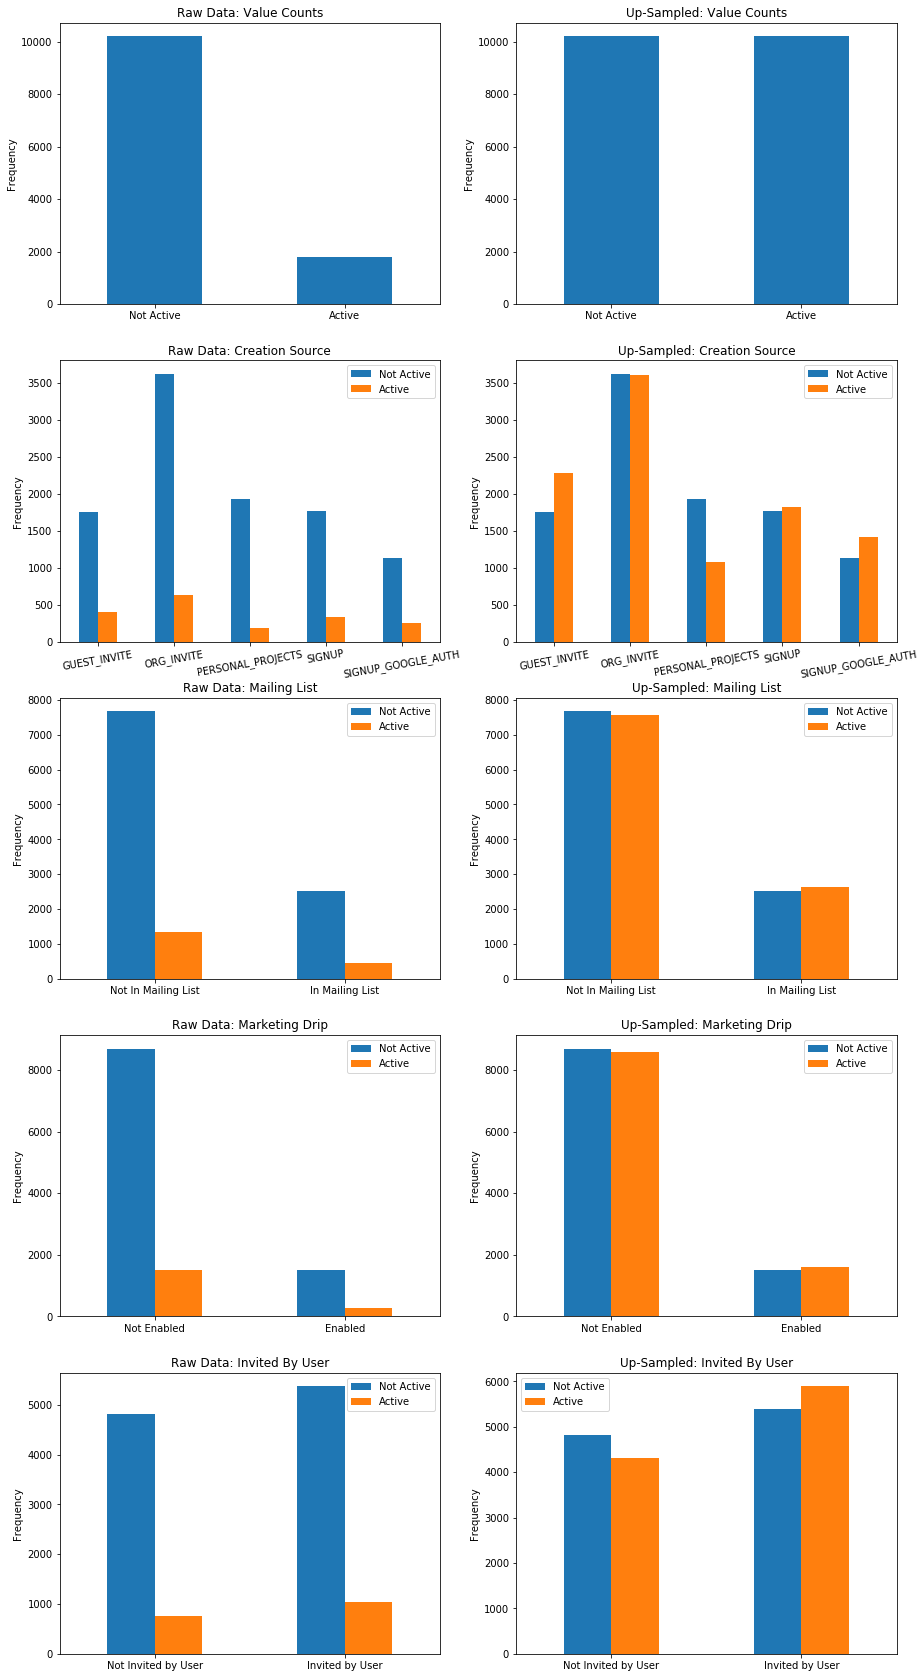

In [220]:
# Plot figures to see differences in un-sampled and resampled datasets
fig, axs = plt.subplots(5,2, figsize=(15,30)) # define subplots

# Raw: Value Counts
users['adopted'].value_counts().plot(kind='bar', ax=axs[0,0])
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('Raw Data: Value Counts')
axs[0,0].set_xticklabels(['Not Adopted', 'Adopted'], rotation=0)

# Resampled: Value Counts
resampled_users['adopted'].value_counts().plot(kind='bar', ax=axs[0,1])
axs[0,1].set_ylabel('Frequency')
axs[0,1].set_title('Up-Sampled: Value Counts')
axs[0,1].set_xticklabels(['Not Adopted', 'Adopted'], rotation=0)

# Raw: Creation Source
users.groupby('adopted').creation_source.value_counts().unstack(0).plot(kind='bar', ax=axs[1,0])
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_xlabel('')
axs[1,0].set_title('Raw Data: Creation Source')
axs[1,0].legend(['Not Adopted', 'Adopted'])
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=10)

# Resampled: Creation Source
resampled_users.groupby('adopted').creation_source.value_counts().unstack(0).plot(kind='bar', ax=axs[1,1])
axs[1,1].set_ylabel('Frequency')
axs[1,1].set_xlabel('')
axs[1,1].set_title('Up-Sampled: Creation Source')
axs[1,1].legend(['Not Adopted', 'Adopted'])
axs[1,1].set_xticklabels(axs[1,0].get_xticklabels(), rotation=10)

# Raw: Mailing List
users.groupby('adopted').opted_in_to_mailing_list.value_counts().unstack(0).plot(kind='bar', ax=axs[2,0])
axs[2,0].set_ylabel('Frequency')
axs[2,0].set_xlabel('')
axs[2,0].set_title('Raw Data: Mailing List')
axs[2,0].legend(['Not Adopted', 'Adopted'])
axs[2,0].set_xticklabels(['Not In Mailing List', 'In Mailing List'], rotation=0)

# Resampled: Mailing List
resampled_users.groupby('adopted').opted_in_to_mailing_list.value_counts().unstack(0).plot(kind='bar', ax=axs[2,1])
axs[2,1].set_ylabel('Frequency')
axs[2,1].set_xlabel('')
axs[2,1].set_title('Up-Sampled: Mailing List')
axs[2,1].legend(['Not Adopted', 'Adopted'])
axs[2,1].set_xticklabels(['Not In Mailing List', 'In Mailing List'], rotation=0)

# Raw: Marketing Drip
users.groupby('adopted').enabled_for_marketing_drip.value_counts().unstack(0).plot(kind='bar', ax=axs[3,0])
axs[3,0].set_ylabel('Frequency')
axs[3,0].set_xlabel('')
axs[3,0].set_title('Raw Data: Marketing Drip')
axs[3,0].legend(['Not Adopted', 'Adopted'])
axs[3,0].set_xticklabels(['Not Enabled', 'Enabled'], rotation=0)

# Resampled: Marketing Drip
resampled_users.groupby('adopted').enabled_for_marketing_drip.value_counts().unstack(0).plot(kind='bar', ax=axs[3,1])
axs[3,1].set_ylabel('Frequency')
axs[3,1].set_xlabel('')
axs[3,1].set_title('Up-Sampled: Marketing Drip')
axs[3,1].legend(['Not Adopted', 'Adopted'])
axs[3,1].set_xticklabels(['Not Enabled', 'Enabled'], rotation=0)

# Raw: Invited by User
users.groupby('adopted').invited_by_user.value_counts().unstack(0).plot(kind='bar', ax=axs[4,0])
axs[4,0].set_ylabel('Frequency')
axs[4,0].set_title('Raw Data: Invited By User')
axs[4,0].legend(['Not Adopted', 'Adopted'])
axs[4,0].set_xlabel('')
axs[4,0].set_xticklabels(['Not Invited by User', 'Invited by User'], rotation=0)

# Resampled: Invited by user
resampled_users.groupby('adopted').invited_by_user.value_counts().unstack(0).plot(kind='bar', ax=axs[4,1])
axs[4,1].set_ylabel('Frequency')
axs[4,1].set_xlabel('')
axs[4,1].set_title('Up-Sampled: Invited By User')
axs[4,1].legend(['Not Adopted', 'Adopted'])
axs[4,1].set_xticklabels(['Not Invited by User', 'Invited by User'], rotation=0)

# Show plots
plt.show()

By upsampling the adopted users, we can see a big difference in the value counts for a lot of different categories. Without balancing the data, it seems like the non-adopted users have higher group values across the board. However, the balanced data show some different trends. For example, it appears that there's the largest difference between non-adopted users and adopted users in creation sources of personal projects and guest invites. In addition, there may be a fundamental difference in adopted/non-adopted users as to whether or not they're invited by someone else. These two groups of categories may be most influential in our machine learning model below. 

For this exercise, I will use a Random Forest to predict whether or not an individual is considered an adopted user. Although there are several other methods I could use (Decision Tree, Gradient Booster, K Nearest Neighbors, etc), I have decided to use a Random Forest because 1) it should be more precise than a single decision tree, 2) it allows me to expand my experience beyond gradient boosting classifiers, and 3) it allows me to see the most influential features, which K Nearest Neighbors does not.

In [177]:
# Import machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [181]:
# Build an easy function to get precision and recall
# from the confusion matrix
def precision_recall_calc(true, predicted):
    """"""" Calculates precision and recall scores for a particular model """""""
    cm = confusion_matrix(true, predicted)
    p = cm[0,0]/(cm[0,0] + cm[1,0])
    r = cm[0,0]/(cm[0,0] + cm[0,1])
    return p, r

In [201]:
# Split data into predictors and responses
response = resampled_users.adopted.copy().astype('category')
predictors = resampled_users[['opted_in_to_mailing_list', 
                              'enabled_for_marketing_drip',
                              'invited_by_user', 'org_id',
                              'creation_source']].copy()

# One-Hot Encoding for Predictors
predictors = predictors.astype('category')
predictors = pd.get_dummies(predictors, drop_first=True)

In [202]:
# Split dataset into training set and test set to see model performance
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.25, random_state=33) 

I perform a grid search for the Random Forest Classifier below, so that I can choose the appropriate hyperparameters. I am choosing not to bootstrap the samples because I don't want to miss any trends in the data (and because I already bootstrapped above when re-sampling for adopted users).

In [230]:
# Grid Search for random forest
parameters = {'n_estimators':[10,100,150],'max_depth':[3,6,8]}
    # Set parameters
rf = RandomForestClassifier(bootstrap=False, random_state=33)
    # set classifier
clf = GridSearchCV(rf, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'max_depth': 8, 'n_estimators': 150}


The best model seems to have a maximum depth of 8 and 150 trees in the forest. If we were to expand our potential maximum depths more, it's likely that the best model would have an even higher maximum depth. However, the goal here is to come up with the simplest model that provides decent results. Adding a larger maximum depth would make the results much more difficult to interpret.

In [231]:
# Create model
rf = RandomForestClassifier(max_depth=8, n_estimators=150, bootstrap=False, random_state=33)
rf.fit(X_train, y_train) # train the data

# Get the prediction values for the training and testing data
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)

# Print results
print('Training Precision: ' + str(precision_recall_calc(y_train, y_pred_train)[0]))
print('Testing Precision: ' + str(precision_recall_calc(y_test, y_pred)[0]))

Training Precision: 0.6604844814534444
Testing Precision: 0.6252955082742316


The good news is that the model does not seem to be severely overfitting the training data, or simply memorizing the answers to the training dataset. This is seen because the testing and training precision values are similar (0.66 and 0.63). The bad news is that this model doesn't really give us very good precision scores. It's not bad, but we still risk being incorrect 40% of the time. This likely means that there is another factor, not included in the dataset, that is driving the difference in adopted and not adopted users. Below, I will generate the four features in the model that seem to be contributing the most to the model output. I chose four features arbitrarily in this example.

In [233]:
# Find the top four features that are most important here
features = pd.DataFrame({'feature':X_train.columns, 
                         'importance':rf.feature_importances_})
    # create data frame of feature importances
features = features[features.importance > 0].sort_values(
    by='importance',ascending=False).reset_index(drop=True)
    # only keep those > 0 and sort by importance
print(features[0:4]) # print

                              feature  importance
0   creation_source_PERSONAL_PROJECTS    0.165153
1                 invited_by_user_1.0    0.083901
2          opted_in_to_mailing_list_1    0.052389
3  creation_source_SIGNUP_GOOGLE_AUTH    0.045746


It seems like people who have created the account for personal projects is the most important feature in this model. We did note this above, where the biggest difference between adopted and non-adopted users appeared to be in the personal projects category for the creation source. We also noted differences above in users that were invited by another user, which seems to be the second most important feature in the model. From those trends, it seems like adopted users are more likely to have been invited by a pre-existing user than non-adopted users. The next groups that seem to be driving the model is if the user has opted into the mailing list (though the plots above do not seem to agree on this conclusion) and users that have signed up using Google Authentication. The latter group may be supported by the preliminary figures created above, as adopted users contribute more to this group than the non-adopted users. 

Nonetheless, it appears that there is another factor that we have failed to added to the model that might be a better tell for whether a user will become adopted or not. I would have liked to be able to incorporate the difference in time from the most recent login of a user and the date the data were pulled. This may be a useful feature in predicting users that are about to turn into 'adopted users,' because they may be starting to use the site more. Perhaps it might be useful to determine whether individuals that have signed up for the service are in school (university students often need help prioritizing tasks) or in industry, and to see how long individuals stayed on the site each time that they logged on (individuals who are using the site for long durations of time may be more likely to use the site more regularly).